In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import models as M
from train import load_data
import yaml
from tqdm import tqdm
import os

from torchmetrics.classification import BinaryCalibrationError
from sklearn.calibration import CalibrationDisplay
import torch
import ml_insights as mli
!nvidia-smi

Sun Nov 19 00:16:59 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX 6000 Ada Gener...    On | 00000000:1A:00.0 Off |                  Off |
| 30%   31C    P8               23W / 300W|  47111MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [64]:
N_BINS=20

In [2]:
_, _, x_val, y_val, x_test, y_test = load_data('outbound')


======== loadiing train and test data ==========
load x_train
load y_train
load x_test
load x_test
load x_val
load y_val
...load complete.
imported training data:
x_train shape: (12220423, 246)
y_train shape: (12220423,)
[(0.0, 11968256), (1.0, 252167)]
imported validation data:
x_val shape: (1359116, 246)
y_val shape: (1359116,)
[(0.0, 1330995), (1.0, 28121)]
imported test data:
x_test shape: (3585960, 246)
y_test shape: (3585960,)
[(0.0, 3496912), (1.0, 89048)]


# Outbound

# DNN

In [3]:
DNN_MODEL = '/smallwork/alexander.huang/models/2023-11-18/49595396_outbound_dnn_run_2023-11-18 14:21:45.406099/checkpoint97-0.06.h5'
DNN_PARAMS = '/smallwork/alexander.huang/models/2023-11-18/49595396_outbound_dnn_run_2023-11-18 14:21:45.406099/params.yml'

with open(DNN_PARAMS) as file:
    dnn_params = yaml.load(file, Loader=yaml.loader.FullLoader)

dnn_model = M.get_dnn_model(dnn_params)
dnn_model.load_weights(DNN_MODEL)
dnn_model.summary()

Model: "dnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 246)]             0         
                                                                 
 hidden_1 (Dense)            (None, 512)               126464    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 hidden_2 (Dense)            (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 output (Dense)              (None, 2)                 1026      
                                                                 
Total params: 390146 (1.49 MB)
Trainable params: 390146 (1.49 M

2023-11-19 00:12:44.232517: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46497 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:1a:00.0, compute capability: 8.9


In [5]:
#dnn_pred_val = dnn_model.predict(x_val)

  113/42473 [..............................] - ETA: 57s   

2023-11-19 00:17:20.429195: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


42473/42473 [==============================] - 59s 1ms/step


In [6]:
#print(dnn_pred_val.shape)

(1359116, 2)


In [49]:
#CALIBRATION_FILES = '/smallwork/alexander.huang/calibration/'
#os.makedirs(CALIBRATION_FILES, exist_ok=True)

In [8]:
#np.save(CALIBRATION_FILES + 'dnn_val_predictions.npy', dnn_pred_val)

In [84]:
dnn_pred_test = np.load('/smallwork/alexander.huang/mcdropout/outbound/49595416/dnn_predictions.npy')

In [85]:
dnn_pred_test.shape

(3585960, 2)

In [86]:
dnn_pred_pos = dnn_pred_test[:,1]

In [87]:
metric = BinaryCalibrationError(n_bins=N_BINS, norm='l1')

In [88]:
dnn_pos_tensor = torch.from_numpy(dnn_pred_pos)
y_test_tensor = torch.from_numpy(y_test)
metric(dnn_pos_tensor, y_test_tensor).numpy()

array(0.03460985, dtype=float32)

# Concrete Dropout

In [89]:
cd_pred = np.load('/smallwork/alexander.huang/concrete_dropout/outbound/49595417/predictions.npy')
cd_pred_mean = np.mean(cd_pred, axis=0)
cd_pred_pos = cd_pred_mean[:,1]
print(cd_pred_pos.shape)
print(cd_pred_pos)

(3585960,)
[0.00439331 0.00452989 0.01267755 ... 0.00368847 0.55808026 0.5341562 ]


In [90]:
cd_pred_pos_tensor = torch.from_numpy(cd_pred_pos)
y_test_tensor = torch.from_numpy(y_test)
metric(cd_pred_pos_tensor, y_test_tensor).numpy()

array(0.03273876, dtype=float32)

# MC Dropout

In [91]:
mcd_pred = np.load('/smallwork/alexander.huang/mcdropout/outbound/49595416/mcd_predictions.npy')

In [92]:
mcd_pred_mean = np.mean(mcd_pred, axis=0)
mcd_pred_pos = mcd_pred_mean[:,1]
print(mcd_pred_pos.shape)
print(mcd_pred_pos)

(3585960,)
[0.00412965 0.00453834 0.01160647 ... 0.00516901 0.549093   0.5068372 ]


In [93]:
mcd_pred_pos_tensor = torch.from_numpy(mcd_pred_pos)
metric(mcd_pred_pos_tensor, y_test_tensor).numpy()

array(0.03302699, dtype=float32)

In [94]:
print('DNN ECE:', metric(dnn_pos_tensor, y_test_tensor).numpy())
print('Concrete Dropout ECE:', metric(cd_pred_pos_tensor, y_test_tensor).numpy())
print('MC Dropout ECE:', metric(mcd_pred_pos_tensor, y_test_tensor).numpy())

DNN ECE: 0.034609847
Concrete Dropout ECE: 0.032738756
MC Dropout ECE: 0.033026993


# Combined Calibration Plot

Text(0.5, 1.0, 'Calibration, Outbound Models, bins=20')

<Figure size 5000x5000 with 0 Axes>

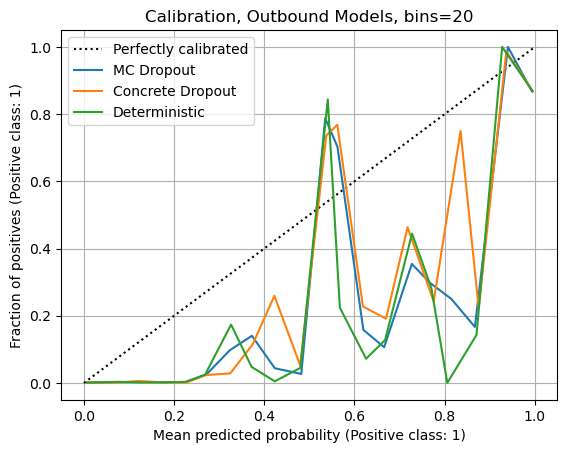

In [95]:
fig = plt.figure(figsize=(50,50))
fig, ax = plt.subplots()
display = CalibrationDisplay.from_predictions(y_test, mcd_pred_pos, n_bins=N_BINS, marker=None, name='MC Dropout', ax=ax, pos_label=1)
display = CalibrationDisplay.from_predictions(y_test, cd_pred_pos, n_bins=N_BINS, marker=None, name='Concrete Dropout', ax=ax, pos_label=1)
display = CalibrationDisplay.from_predictions(y_test, dnn_pred_pos, n_bins=N_BINS, marker=None, name='Deterministic', ax=ax, pos_label=1)
ax.legend(loc='upper left')
plt.grid()
plt.title(f'Calibration, Outbound Models, bins={N_BINS}')


## Below code is regression models for calibrated classifiers, not used.

In [ ]:
#mli.plot_reliability_diagram(y_test, cd_pred_pos, marker='.', bins=np.linspace(0,1,31), error_bars=False)

In [ ]:
cd_val_pred = np.load('cd_val_predictions.npy')

In [ ]:
cd_val_mean = np.mean(cd_val_pred, axis=0)

In [ ]:
spline = mli.SplineCalib()
# fit calibration model on validation data
spline.fit(cd_val_mean[:,1], y_val)

In [ ]:
mli.plot_reliability_diagram(y_val, cd_val_mean[:,1]);

In [19]:
# test on test set
preds_test_spline = spline.calibrate(cd_pred_mean)

{'pred_probs': array([0.00336978, 0.05280265, 0.07267189, 0.11548552, 0.14602736,
        0.18877621, 0.21926697, 0.24262891, 0.27877636, 0.31009651,
        0.35141824, 0.37823168, 0.41349309, 0.44200984, 0.48464069,
        0.50288578, 0.63024901, 0.65093908, 0.684977  , 0.71358806,
        0.74346461, 0.79313477, 0.80661423, 0.85841763, 0.88417467,
        0.92572015, 0.95215435, 0.96793515]),
 'emp_probs': array([0.00128794, 0.00789263, 0.02767454, 0.17263509, 0.21509226,
        0.04800681, 0.86335874, 0.44349211, 0.28040972, 0.04194631,
        0.24285714, 0.38016528, 0.44117647, 0.2857143 , 0.17647059,
        1.        , 1.        , 0.33333334, 0.        , 0.85714287,
        1.        , 1.        , 1.        , 1.        , 0.93908632,
        0.69116527, 0.90607345, 0.94885325]),
 'bin_counts': array([3.296745e+06, 1.163110e+05, 5.246700e+04, 7.791000e+03,
        3.631000e+03, 8.228000e+03, 7.579700e+04, 1.318400e+04,
        1.562000e+03, 5.960000e+02, 2.100000e+02, 1.210000e

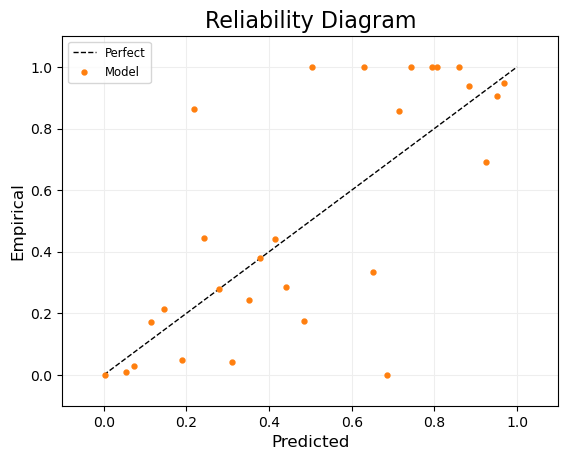

In [20]:
mli.plot_reliability_diagram(y_test, preds_test_spline[:,1], marker='.', bins=np.linspace(0,1,31), error_bars=False)

In [21]:
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

In [22]:
# isotonic regressor
isotonic = IsotonicRegression()
isotonic.fit(cd_val_mean[:,1], y_val)

IsotonicRegression()

In [23]:
# sigmoid
logistic = LogisticRegression(C=99999999999)
logistic.fit(cd_val_mean[:,1].reshape(-1,1), y_val)

LogisticRegression(C=99999999999)

In [24]:
preds_test_iso = isotonic.predict(cd_pred_mean[:,1])

In [25]:
preds_test_platt = logistic.predict_proba(cd_pred_mean[:,1].reshape(-1,1))

Text(0.5, 1.0, 'Calibration')

<Figure size 5000x5000 with 0 Axes>

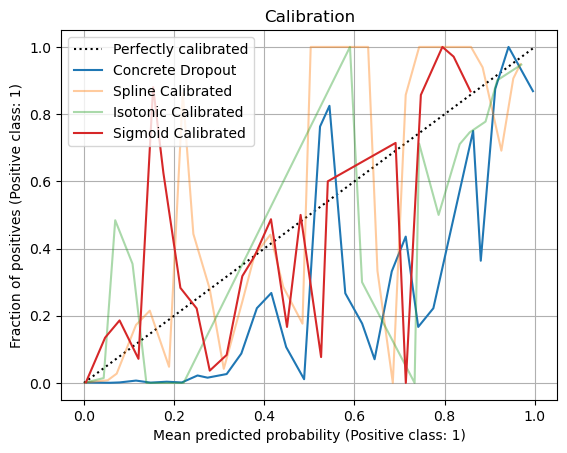

In [26]:
bins=30

fig = plt.figure(figsize=(50,50))
fig, ax = plt.subplots()
display = CalibrationDisplay.from_predictions(y_test, cd_pred_pos, n_bins=bins, marker=None, name='Concrete Dropout', ax=ax, pos_label=1, alpha=1)
display = CalibrationDisplay.from_predictions(y_test, preds_test_spline[:,1], marker=None, n_bins=bins, name='Spline Calibrated', ax=ax, pos_label=1, alpha=0.4)
display = CalibrationDisplay.from_predictions(y_test, preds_test_iso, n_bins=bins, marker=None, name='Isotonic Calibrated', ax=ax, pos_label=1, alpha=0.4)
display = CalibrationDisplay.from_predictions(y_test, preds_test_platt[:,1], n_bins=bins, marker=None, name='Sigmoid Calibrated', ax=ax, pos_label=1, alpha=1)

ax.legend(loc='upper left')
plt.grid()
plt.title('Calibration')

In [27]:
mcd_metric = BinaryCalibrationError(n_bins=bins, norm='l1')

cd_pred_pos_tensor = torch.from_numpy(cd_pred_pos)
spline_tensor = torch.from_numpy(preds_test_spline[:,1])
iso_tensor = torch.from_numpy(preds_test_iso)
platt_tensor = torch.from_numpy(preds_test_platt[:,1])

uncalibrated_ece = metric(cd_pred_pos_tensor, y_test_tensor).numpy()
spline_ece = metric(spline_tensor, y_test_tensor).numpy()
iso_ece = metric(iso_tensor, y_test_tensor).numpy()
platt_ece = metric(platt_tensor, y_test_tensor).numpy()

print('Uncalibrated concrete dropout ECE:', uncalibrated_ece)
print('Spline ECE:', spline_ece)
print('Isotonic ECE:', iso_ece)
print('Sigmoid ECE:', platt_ece)

Uncalibrated concrete dropout ECE: 0.03331269
Spline ECE: 0.019177558840205854
Isotonic ECE: 0.02099892
Sigmoid ECE: 0.01899811074895223


In [28]:
calib_classes = np.argmax(preds_test_platt, axis=1)

In [31]:
print(classification_report(y_test, calib_classes))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99   3496914
         1.0       0.87      0.09      0.16     89048

    accuracy                           0.98   3585962
   macro avg       0.92      0.55      0.58   3585962
weighted avg       0.97      0.98      0.97   3585962



# Inbound

In [96]:
_, _, _, _, ix_test, iy_test = load_data('inbound')


======== loadiing train and test data ==========
load x_train
load y_train
load x_test
load x_test
load x_val
load y_val
...load complete.
imported training data:
x_train shape: (9884082, 381)
y_train shape: (9884082,)
[(0.0, 9734538), (1.0, 149544)]
imported validation data:
x_val shape: (1354514, 381)
y_val shape: (1354514,)
[(0.0, 1333989), (1.0, 20525)]
imported test data:
x_test shape: (3583152, 381)
y_test shape: (3583152,)
[(0.0, 3518136), (1.0, 65016)]


In [97]:
dnn_pred_test = np.load('/smallwork/alexander.huang/mcdropout/inbound/49595425/dnn_predictions.npy')

In [98]:
metric = BinaryCalibrationError(n_bins=N_BINS, norm='l1')

In [99]:
dnn_pred_pos = dnn_pred_test[:,1]
dnn_pos_tensor = torch.from_numpy(dnn_pred_pos)
y_test_tensor = torch.from_numpy(y_test)

In [100]:
cd_pred = np.load('/smallwork/alexander.huang/concrete_dropout/inbound/49595427/predictions.npy')
cd_pred_mean = np.mean(cd_pred, axis=0)
cd_pred_pos = cd_pred_mean[:,1]

cd_pred_pos_tensor = torch.from_numpy(cd_pred_pos)
y_test_tensor = torch.from_numpy(iy_test)

In [101]:
mcd_pred = np.load('/smallwork/alexander.huang/mcdropout/inbound/49595425/mcd_predictions.npy')
mcd_pred_mean = np.mean(mcd_pred, axis=0)
mcd_pred_pos = mcd_pred_mean[:,1]
print(mcd_pred_pos.shape)
print(mcd_pred_pos)

mcd_pred_pos_tensor = torch.from_numpy(mcd_pred_pos)

(3583152,)
[0.4019553  0.00481305 0.00637838 ... 0.02767996 0.59041095 0.00605387]


In [102]:
print('DNN ECE:', metric(dnn_pos_tensor, y_test_tensor).numpy())
print('Concrete Dropout ECE:', metric(cd_pred_pos_tensor, y_test_tensor).numpy())
print('MC Dropout ECE:', metric(mcd_pred_pos_tensor, y_test_tensor).numpy())

DNN ECE: 0.09291932
Concrete Dropout ECE: 0.100418314
MC Dropout ECE: 0.09313769


Text(0.5, 1.0, 'Calibration, Inbound Models, bins=20')

<Figure size 5000x5000 with 0 Axes>

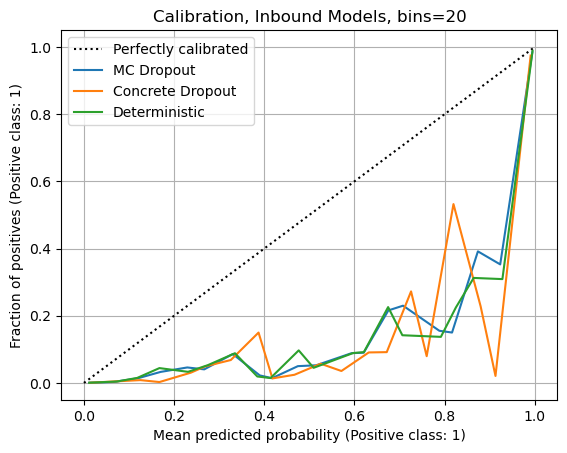

In [103]:
fig = plt.figure(figsize=(50,50))
fig, ax = plt.subplots()
display = CalibrationDisplay.from_predictions(iy_test, mcd_pred_pos, n_bins=N_BINS, marker=None, name='MC Dropout', ax=ax, pos_label=1)
display = CalibrationDisplay.from_predictions(iy_test, cd_pred_pos, n_bins=N_BINS, marker=None, name='Concrete Dropout', ax=ax, pos_label=1)
display = CalibrationDisplay.from_predictions(iy_test, dnn_pred_pos, n_bins=N_BINS, marker=None, name='Deterministic', ax=ax, pos_label=1)
ax.legend(loc='upper left')
plt.grid()
plt.title(f'Calibration, Inbound Models, bins={N_BINS}')